In [1]:
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [ ]:
from glob import glob
from itertools import islice

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy
import seaborn as sns
import torch
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from skimage.segmentation import mark_boundaries
from lime import lime_image

from era_data import TabletEraDataset
from era_model import EraClassifier

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Load data and model

In [6]:
! ls lightning_logs

era_clf_bs16_lr5e-05_10epochs-resnet50-92327_samples_March27


In [7]:
VERSION_NAME = 'era_clf_bs16_lr5e-05_10epochs-resnet50-92327_samples_March27'

In [8]:
ckpt_fns = glob('lightning_logs/*/checkpoints/*')
ckpt_fns

['lightning_logs/era_clf_bs16_lr5e-05_10epochs-resnet50-92327_samples_March27/checkpoints/epoch=9-step=57400.ckpt']

In [9]:
CKPT_FN = glob(f'lightning_logs/{VERSION_NAME}/checkpoints/*')[0]
CKPT_FN

'lightning_logs/era_clf_bs16_lr5e-05_10epochs-resnet50-92327_samples_March27/checkpoints/epoch=9-step=57400.ckpt'

In [10]:
%time model = EraClassifier.load_from_checkpoint(CKPT_FN)

/home/kapond/.conda/envs/dani_torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kapond/.conda/envs/dani_torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CPU times: user 1.02 s, sys: 611 ms, total: 1.63 s
Wall time: 4.8 s


In [11]:
model.to(device);

In [12]:
model.eval();

In [13]:
! ls output/clf_ids

era-test-era_clf_bs16_lr5e-05_10epochs-resnet50-92327_samples_March27.csv
era-test-era_clf_bs16_lr5e-05_3epochs-resnet50-103384_samples.csv
era-test-era_clf_bs16_lr5e-05_3epochs-resnet50-97012_samples.csv
era-train-era_clf_bs16_lr5e-05_10epochs-resnet50-92327_samples_March27.csv
era-train-era_clf_bs16_lr5e-05_3epochs-resnet50-103384_samples.csv
era-train-era_clf_bs16_lr5e-05_3epochs-resnet50-97012_samples.csv
genre-test-genre_clf_bs16_lr5e-05_15epochs-resnet50-97640_samples-masked-Sept_19_blur-early_stopping.csv
genre-test-genre_clf_bs16_lr5e-05_15epochs-resnet50-97640_samples-masked-Spet_18_blur.csv
genre-train-genre_clf_bs16_lr5e-05_15epochs-resnet50-97640_samples-masked-Sept_19_blur-early_stopping.csv
genre-train-genre_clf_bs16_lr5e-05_15epochs-resnet50-97640_samples-masked-Spet_18_blur.csv
period-test-genre_clf_bs16_lr5e-05_15epochs-resnet50-97640_samples-masked-Spet_18_blur.csv
period-test-period_clf_bs16_lr0.001_3epochs-vanillaCNN-97640_samples-preprocessed2.csv
period-test-perio

In [15]:
train_ids = pd.read_csv(f'output/clf_ids/era-train-era_clf_bs16_lr5e-05_10epochs-resnet50-92327_samples_March27.csv', header=None)[0].astype(str)
test_ids = pd.read_csv(f'output/clf_ids/era-test-era_clf_bs16_lr5e-05_10epochs-resnet50-92327_samples_March27.csv', header=None)[0].astype(str)

In [16]:
len(train_ids), len(test_ids)

(91827, 500)

In [17]:
ds_train = TabletEraDataset(IDS=train_ids)
ds_test = TabletEraDataset(IDS=test_ids)

Filtering 97631 IDS down to provided 91827...
Filtering 97631 IDS down to provided 500...


# Calculate predictions

In [19]:
# dl_train = DataLoader(ds_train, batch_size=16, shuffle=False, num_workers=1)
dl_test = DataLoader(ds_test, batch_size=16, shuffle=False, num_workers=1)

In [20]:
def dl2data(dl, MAX_N=None):
    logits = []
    y_true = []
    with torch.no_grad():
        gen = tqdm(dl) if MAX_N is None else tqdm(islice(dl, MAX_N), total=MAX_N)
        for X, y in gen:
            y_true.append(y.numpy())
            logits.append(model(X.to(device)).cpu().numpy())
    y_true = np.hstack(y_true)
    logits = np.vstack(logits)
    return logits, y_true

In [22]:
# logits_train, y_true_train = dl2data(dl_train)

In [23]:
# logits_train.shape, y_true_train.shape

In [21]:
logits, y_true = dl2data(dl_test)

  0%|          | 0/32 [00:00<?, ?it/s]

In [25]:
y_true.shape, logits.shape

((500,), (500, 3))

In [29]:
# y_pred = clf.predict(logits)
# y_prob = clf.predict_proba(logits)

In [26]:
y_pred = logits.argmax(axis=-1)
y_prob = scipy.special.softmax(logits, axis=-1)

In [27]:
y_pred.shape, y_prob.shape

((500,), (500, 3))

In [28]:
(y_pred == y_true).mean()

0.934

# Check metrics

In [29]:
ERAS = ['early bronze', 'mid/late bronze', 'iron']
ERAS_SHORT = ['EB', 'M/LB', 'Iron']

In [30]:
print(classification_report(y_true, y_pred, target_names=ERAS))

                 precision    recall  f1-score   support

   early bronze       0.96      0.94      0.95       192
mid/late bronze       0.88      0.91      0.90       137
           iron       0.95      0.94      0.94       171

       accuracy                           0.93       500
      macro avg       0.93      0.93      0.93       500
   weighted avg       0.93      0.93      0.93       500



In [31]:
cm = confusion_matrix(y_true, y_pred)
cm # rows: ground truth; cols: prediction

array([[181,   8,   3],
       [  6, 125,   6],
       [  1,   9, 161]])

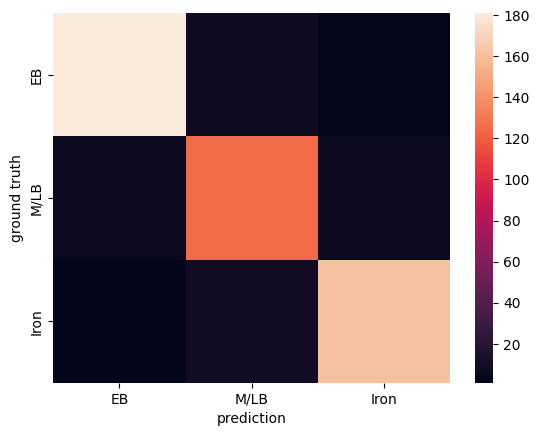

In [32]:
sns.heatmap(cm, xticklabels=ERAS_SHORT, yticklabels=ERAS_SHORT);
plt.xlabel('prediction');
plt.ylabel('ground truth');

In [33]:
for mc in ['ovo', 'ovr']:
    for avg in ['macro', 'weighted']:
        score = roc_auc_score(y_true, y_prob, multi_class=mc, average=avg)
        print(f'{mc} {avg}\t{score:.4f}')

ovo macro	0.9908
ovo weighted	0.9912
ovr macro	0.9912
ovr weighted	0.9918


# Visualize mistakes

In [34]:
mistake_indices = np.where(y_true != y_pred)[0]
mistake_indices

array([  8,  12,  25,  26,  30,  33,  41,  57,  58,  66,  67,  83,  86,
        94, 143, 151, 174, 199, 227, 229, 231, 244, 247, 268, 289, 290,
       294, 300, 326, 354, 365, 382, 446])

In [35]:
mistake_indices.shape

(33,)

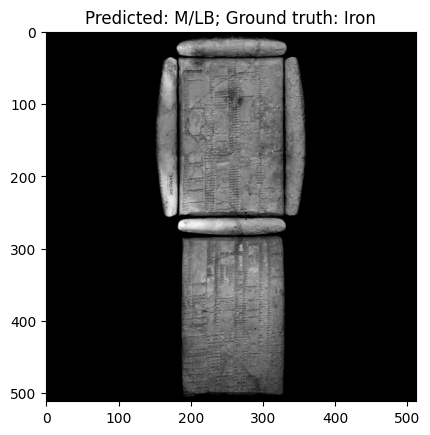

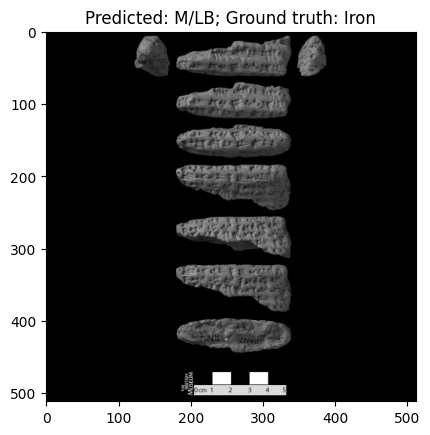

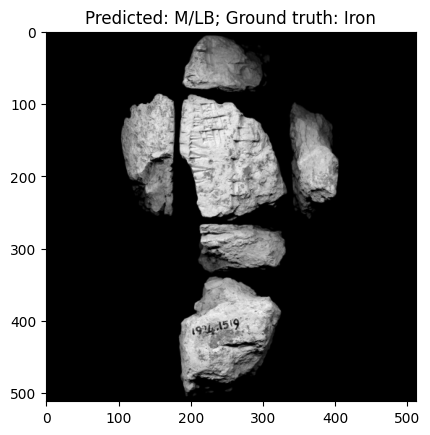

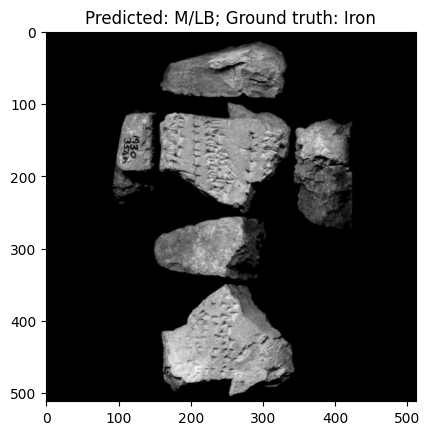

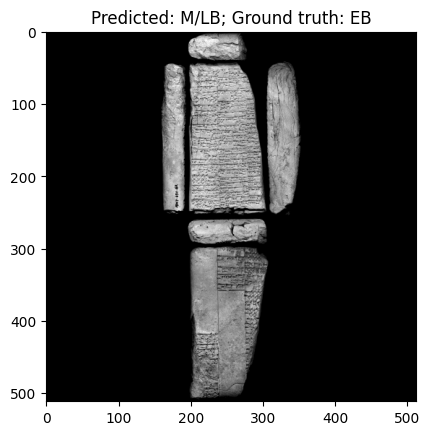

In [36]:
for idx in mistake_indices[:5]:
    
    X, y = ds_test[idx]
    pred = y_pred[idx]
    
    plt.imshow(X, cmap='gray')
    plt.title(f'Predicted: {ERAS_SHORT[pred]}; Ground truth: {ERAS_SHORT[y]}')
    plt.show()

# Explain predictions with Lime

https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20images%20-%20Pytorch.ipynb

In [39]:
pip install lime

  Using cached lime-0.2.0.1.tar.gz (275 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=63ee8dd946d2ee701dd416bc0108b79fe014416ddcbbab4343f24f9eb001044e
  Stored in directory: /sise/home/kapond/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime
Note: you may need to restart the kernel to use updated packages.


In [41]:
def preprocess_transform(img):
    return img

In [42]:
def batch_predict(X):
    assert len(X.shape) == 4
    # Lime adds channel dimension (gray2rgb); we remove it
    # it also requires float64 (double) but our model needs float32
    X_gray = X[..., 0].astype(np.float32) / 255
    logits = model(torch.tensor(X_gray).to(device)).detach().cpu().numpy()
#     probs = clf.predict_proba(logits)
    probs = scipy.special.softmax(logits, axis=-1)
    return probs

In [43]:
explainer = lime_image.LimeImageExplainer()

In [44]:
def explain_idx(idx):
    X, y = ds_test[idx]
    
    explanation = explainer.explain_instance(
        X.astype(np.float64) * 255,
        batch_predict,
    #     top_labels=3,
    #     hide_color=0,
        batch_size=16,
        num_samples=1000
    )
    
    top_label = explanation.top_labels[0]
    
    temp, mask = explanation.get_image_and_mask(
        top_label,
        positive_only=False,
        num_features=20,
        hide_rest=False
    )
    
    img_boundary = mark_boundaries(temp/255.0, mask)
    
    print(f'Item {idx}:')
    print(f'Ground truth:\t{ERAS_SHORT[y]} ({y})')
    print(f'Prediction:\t{ERAS_SHORT[top_label]} ({top_label})')

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(X, cmap='gray');
    axs[1].imshow(img_boundary);
    plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

Item 0:
Ground truth:	Iron (2)
Prediction:	Iron (2)


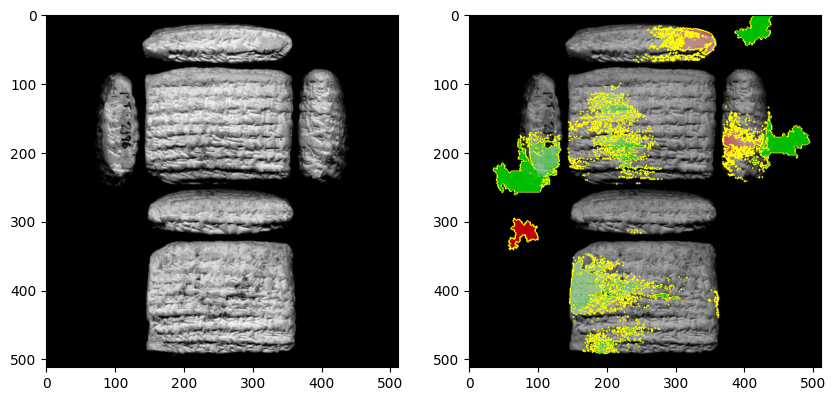

  0%|          | 0/1000 [00:00<?, ?it/s]

Item 1:
Ground truth:	Iron (2)
Prediction:	Iron (2)


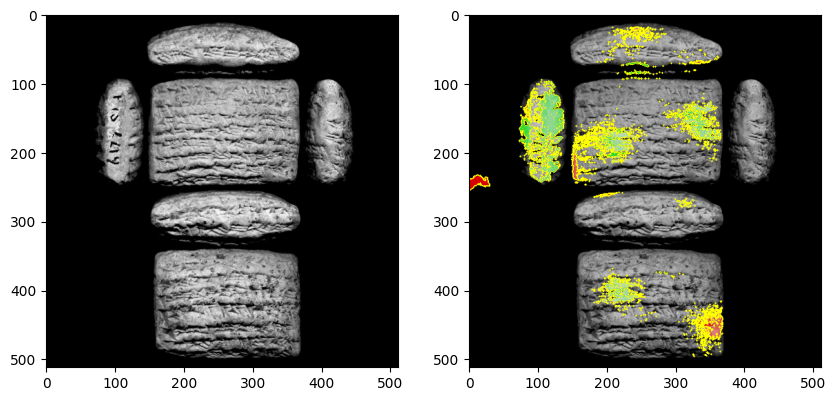

  0%|          | 0/1000 [00:00<?, ?it/s]

Item 2:
Ground truth:	Iron (2)
Prediction:	Iron (2)


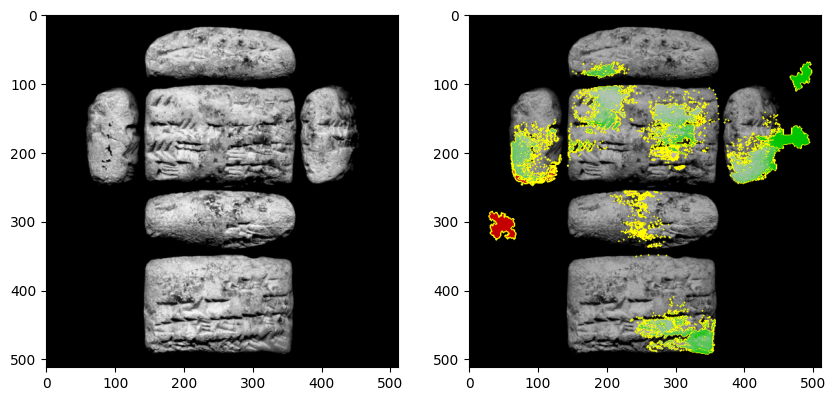

  0%|          | 0/1000 [00:00<?, ?it/s]

Item 3:
Ground truth:	EB (0)
Prediction:	EB (0)


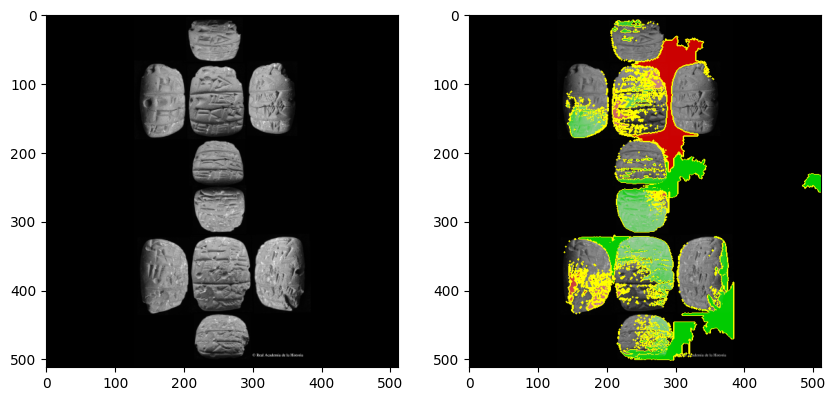

  0%|          | 0/1000 [00:00<?, ?it/s]

Item 4:
Ground truth:	EB (0)
Prediction:	EB (0)


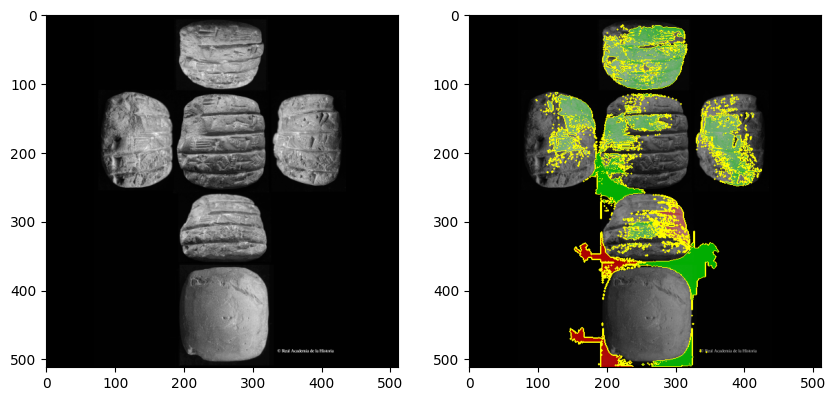

  0%|          | 0/1000 [00:00<?, ?it/s]

Item 5:
Ground truth:	EB (0)
Prediction:	EB (0)


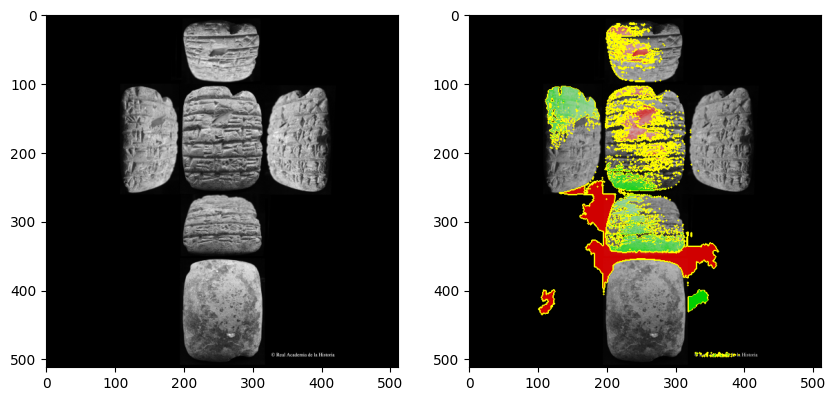

  0%|          | 0/1000 [00:00<?, ?it/s]

Item 6:
Ground truth:	M/LB (1)
Prediction:	M/LB (1)


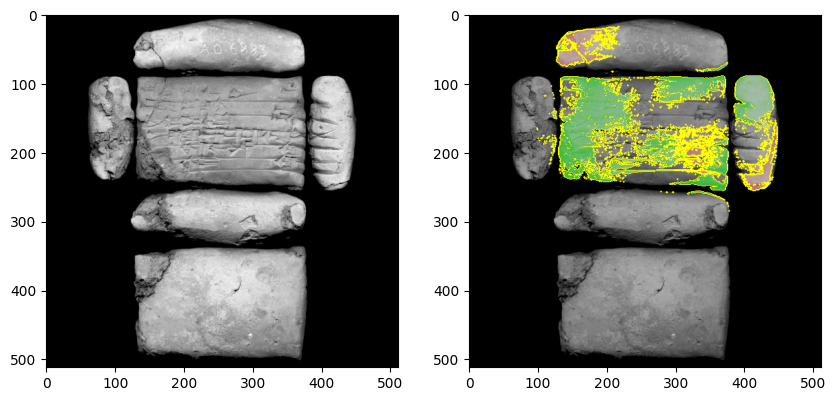

  0%|          | 0/1000 [00:00<?, ?it/s]

Item 7:
Ground truth:	EB (0)
Prediction:	EB (0)


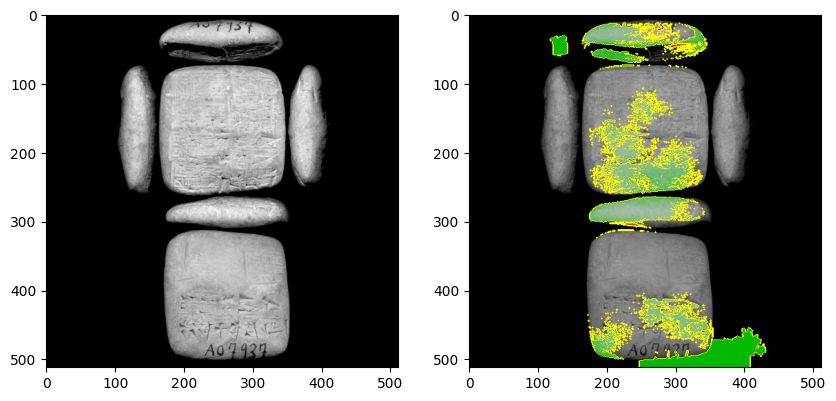

  0%|          | 0/1000 [00:00<?, ?it/s]

Item 8:
Ground truth:	Iron (2)
Prediction:	M/LB (1)


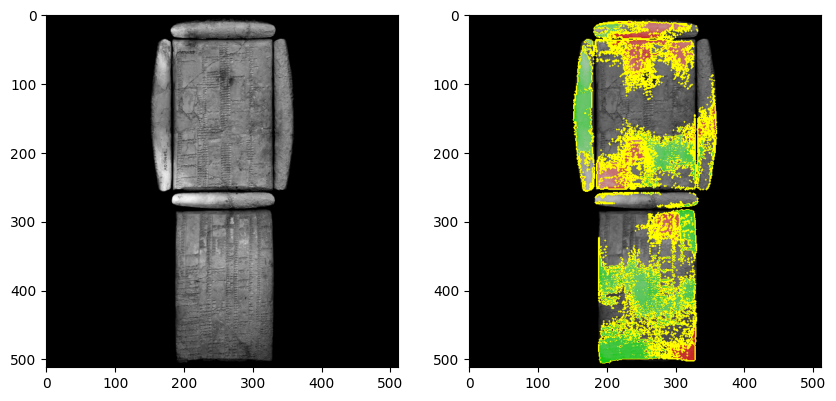

  0%|          | 0/1000 [00:00<?, ?it/s]

Item 9:
Ground truth:	Iron (2)
Prediction:	Iron (2)


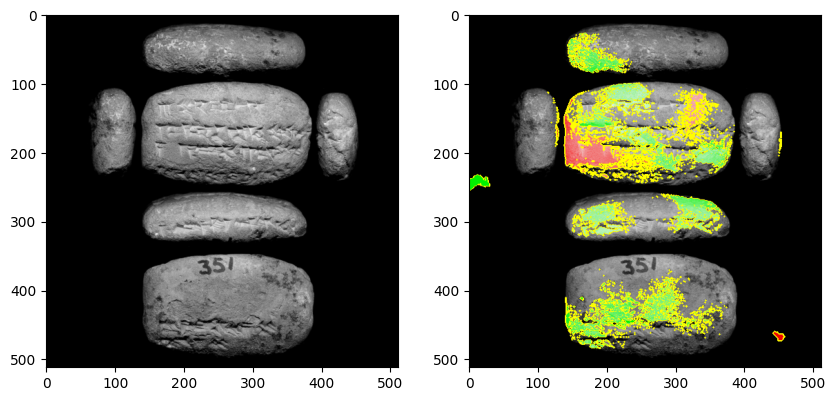

In [45]:
for i in range(10):
    explain_idx(i)